##Clean Data

In [1]:
!pip install stable_baselines3

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SP500_10year_daily.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3275 entries, 0 to 3274
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3275 non-null   object 
 1   value   3275 non-null   float64
dtypes: float64(1), object(1)
memory usage: 51.3+ KB


In [4]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

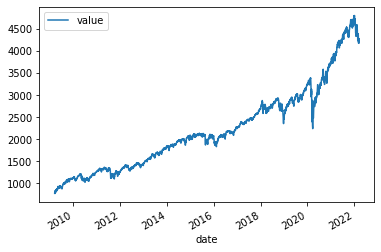

In [5]:
df.plot();

##Make Custom Environment

In [6]:
import gym
from gym import Env
from gym.spaces import *
from stable_baselines3 import DQN
from stable_baselines3.common.policies import *

## TODO

- money to invest (only invest a max of 1k
- more actions - sell 25%, 50%, 75%, or sell all 
- add support for technical indicators

In [7]:
class StockEnv(Env):
  ''' creates a new stock environment with the given dataframe
  - dataframe must already be pre-processed with date data structure as the index
    - i.e. using pd.to_datetime
    - dates must start at earliest time (so row 0 is the earliest time)
  - dataframe must contain price of the stock in a column named 'value'

  - this environment allows us to buy, sell, or hold a stock every day with a discrete action space
    - 0 = buy
    - 1 = sell
    - 2 = hold

  - hyperparameters also include start_index and window_size
    - start_index is the time that we start our data at
    - window_size is the period of time that we want to be looking at previously
      - i.e. 30 days behind 

  '''

  def __init__(self, df, start_index=0, end_index=None, window_size = 30):

    self.df = df
    self.window_size = window_size
    self.end_index = len(self.df.index) if end_index == None else end_index # where we end the data

    self.action_space = Discrete(3)

    spaces = {
    'stock_prices' : Box(low=np.min(self.df)[0], high = np.max(self.df)[0], shape=(self.window_size, ), dtype=np.float32),
    'account_amount' : Box(low = 0, high=np.inf, shape=(1, ), dtype=np.float32)
    }

    self.observation_space = gym.spaces.Dict(spaces)

    self.starting_index = start_index
    self.index = start_index # used for getting the prices
    self.current_time = self.index + self.window_size # the current day we are looking at

    prices = self._get_prices()
    self.shares = 0
    self.state = {"stock_prices" : prices, 'account_amount' : 0}
    self.prev_money = 0
    # a state is a tuple of the current prices we are looking at in the window along with the money we have

    self.money = []
    self.prev_render = []
    self.first_rendering = True



  # gets the prices and increments the index
  def _get_prices(self):
    # if we are at the end of the window
    if self.window_size + self.index > len(self.df.index):
      values = self.df.iloc[self.index:, 0]
      return values.reindex(range(self.window_size), fill_value=0).tolist()

    values = self.df.iloc[self.index:self.window_size + self.index, 0].tolist()

    self.index += 1 # advance to the next timestep
    self.current_time = self.index + self.window_size

    return values

  def _get_today_price(self):
      return self.df['value'][self.current_time-1]


  def step(self, action):

    # calculate state

    if action == 0: # buy
      self.shares += 1

    elif action == 1: # sell
      self.shares = self.shares - 1 if self.shares > 0 else 0

    elif action == 2: # hold
      pass # do nothing

    else:
      raise Exception("Invalid action")

    self.state = {"stock_prices" : self._get_prices(), 'account_amount' : self.shares * self._get_today_price()}

    # calculate reward - how much money we made each timestep/trade
    reward = self.state['account_amount'] - self.prev_money
    self.prev_money = self.state['account_amount']

    self.money.append(self.state['account_amount'])

    # calculate done
    done = self.current_time == self.end_index


    # calculate info
    info = dict()
    info['Current Money'] = self.state['account_amount']
    info['Shares'] = self.shares
    info['Reward'] = reward
    info['Current Timestep'] = self.current_time

    return self.state, reward, done, info


  def render(self, mode='regular'):
    plt.clf()
    if mode == 'dummy':
      y = self.prev_render

    else:
      y = self.money

    plt.plot(self.df.index[self.starting_index:len(y)], y)
    plt.show()
      

  def reset(self, mode=None):
    self.index = self.starting_index
    self.current_time = self.index + self.window_size

    prices = self._get_prices()
    self.shares = 0
    self.state = {"stock_prices" : prices, 'account_amount' : 0}
    self.prev_money = 0

    self.prev_render = self.money
    self.money = []
    self.first_rendering = True


    return self.state

  def close(self):
        plt.close()

In [8]:
env = StockEnv(df)

env.observation_space.sample()

OrderedDict([('account_amount', array([1.325736], dtype=float32)),
             ('stock_prices',
              array([2419.915 , 2288.7546, 2544.3135, 4603.1523, 3827.7925, 1541.7147,
                     4778.3867, 2263.5505, 2802.2644, 4729.7705, 1071.3337, 1206.3282,
                     4772.339 , 3525.1267, 4000.1814, 2503.4355, 2381.156 , 1333.899 ,
                     3402.9277, 2216.368 , 3489.9446, 4562.277 , 2124.911 , 3229.818 ,
                     3580.7893, 3654.1506, 1741.4215, 4468.767 , 2740.795 , 3223.78  ],
                    dtype=float32))])

Episode:0 Reward 561.9100000000035 


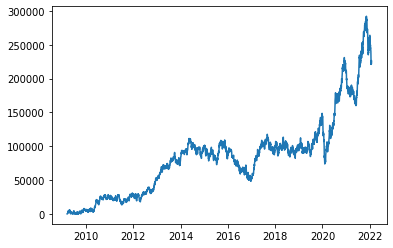

In [9]:
episodes = 1

for episode in range(episodes):
  state = env.reset()
  done = False
  score = 0

  while not done:

      action = env.action_space.sample()
      next_state, reward, done, info = env.step(action)
      
      score += reward

  print("Episode:{} Reward {} ".format(episode, reward))
  env.render()
                                              

## Rl Train

In [10]:
results = []

env = StockEnv(df)
env = DummyVecEnv([lambda : env])

policy_kwargs = dict(activation_fn=tf.nn.ReLU,
                     net_arch=[128, 128, 128]
model = DQN("MultiInputPolicy", env, verbose=1, policy_kwargs=policy_kwargs)
model = model.learn(total_timesteps=100000, log_interval=10)

Using cuda device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10       |
|    fps              | 926      |
|    time_elapsed     | 35       |
|    total_timesteps  | 32440    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20       |
|    fps              | 834      |
|    time_elapsed     | 77       |
|    total_timesteps  | 64880    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.18e+04 |
|    n_updates        | 3719     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 30       |
|    fps              | 627      |
| 

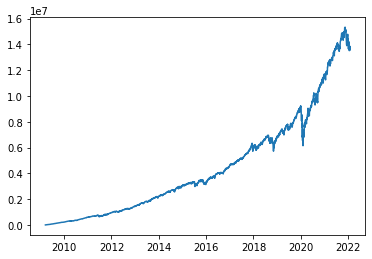

[{'Current Money': 13827387.799999999, 'Shares': 3244, 'Reward': 293992.0700000003, 'Current Timestep': 3275, 'terminal_observation': {'stock_prices': [4515.55, 4546.54, 4589.38, 4477.44, 4500.53, 4483.87, 4521.54, 4587.18, 4504.08, 4418.64, 4401.67, 4471.07, 4475.01, 4380.26, 4348.87, 4304.76, 4225.5, 4288.7, 4384.65, 4373.94, 4306.26, 4386.54, 4363.49, 4328.87, 4201.09, 4170.7, 4277.88, 4259.52, 4204.31, 4173.11], 'account_amount': 13827387.799999999}}]


In [12]:
obs = env.reset()
while True:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    
    if done:
      env.render(mode='dummy')
      print(info)
      results.append(info[0]['Current Money'])
      break

## Dict Observation Space

In [13]:
from stable_baselines3.ppo.ppo import PPO

model = PPO("MultiInputPolicy", env, verbose=1)
model = model.learn(total_timesteps=100000, log_interval=10)

Using cuda device
-------------------------------------------
| time/                   |               |
|    fps                  | 269           |
|    iterations           | 10            |
|    time_elapsed         | 76            |
|    total_timesteps      | 20480         |
| train/                  |               |
|    approx_kl            | 0.00056349597 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1            |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 2.63e+08      |
|    n_updates            | 90            |
|    policy_gradient_loss | -0.00122      |
|    value_loss           | 5.87e+08      |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 278           |
|    iterations           | 20            |
|    time_elap

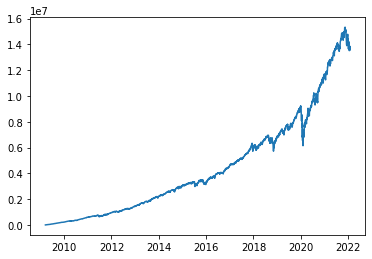

[{'Current Money': 13827387.799999999, 'Shares': 3244, 'Reward': 293992.0700000003, 'Current Timestep': 3275, 'terminal_observation': {'stock_prices': [4515.55, 4546.54, 4589.38, 4477.44, 4500.53, 4483.87, 4521.54, 4587.18, 4504.08, 4418.64, 4401.67, 4471.07, 4475.01, 4380.26, 4348.87, 4304.76, 4225.5, 4288.7, 4384.65, 4373.94, 4306.26, 4386.54, 4363.49, 4328.87, 4201.09, 4170.7, 4277.88, 4259.52, 4204.31, 4173.11], 'account_amount': 13827387.799999999}}]


In [15]:
obs = env.reset()
while True:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)

    if done:
      env.render(mode='dummy')
      print(info)
      results.append(info[0]['Current Money'])
      break

In [18]:
results

[13827387.799999999, 13827387.799999999]